## 分析ケース②: MLアルゴリズムへの差分プライバシー適用

In [1]:
!pip install diffprivlib

/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_948393/3754234034.py:46: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


Non-DP accuracy:  0.6444644464446445


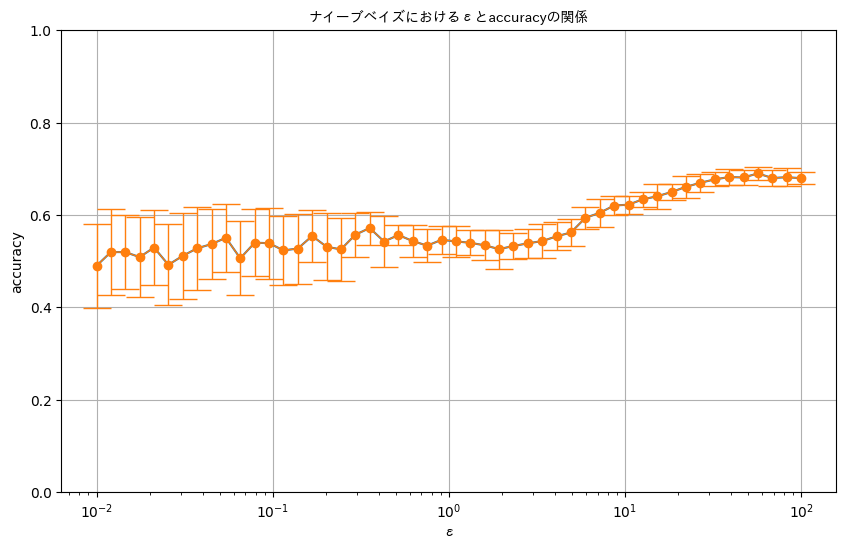

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
import numpy as np
import spacy
from typing import List, Tuple
import itertools
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB as DPGaussianNB
import matplotlib.font_manager as fm

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)
# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = [list(x) for x in X_train]
X_test = [list(x) for x in X_test]

# 差分プライバシーなしのナイーブベイズ
clf = SklearnGaussianNB()
clf.fit(X_train, y_train)
print("Non-DP accuracy: ", clf.score(X_test, y_test))

# 差分プライバシーありのナイーブベイズ
epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train).shape[1]
lowers = np.zeros(dim)
uppers = np.ones(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for _ in range(20):
        dp_clf = DPGaussianNB(bounds=(lowers, uppers), epsilon=epsilon)
        dp_clf.fit(X_train, y_train)
        accuracy.append(dp_clf.score(X_test, y_test))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε', fontproperties=font_prop)
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('ナイーブベイズにおけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()

## ロジスティック回帰

In [3]:

from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
import numpy as np
import spacy
from typing import List, Tuple
import itertools
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB as DPGaussianNB
import matplotlib.font_manager as fm

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)
# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = [list(x) for x in X_train]
X_test = [list(x) for x in X_test]
# 差分プライバシーなしのロジスティック回帰
clf = LogisticRegression(random_state=0).fit(X_train, y_train.to_numpy())
print("Non-DP accuracy: ", clf.score(X_test, y_test.to_numpy()))


/tmp/ipykernel_948393/1424478305.py:47: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


Non-DP accuracy:  0.7155715571557155


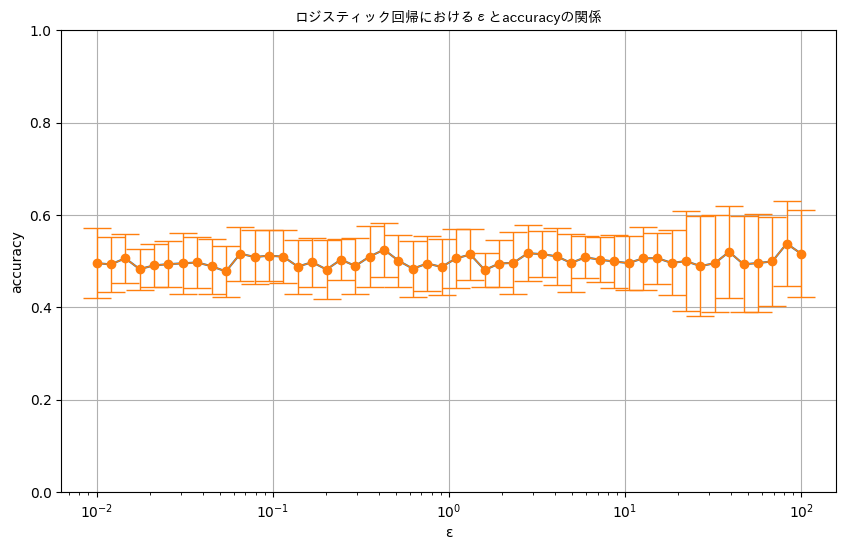

In [4]:

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0).fit(X_train, y_train.to_numpy())
# print(&quot;accuracy: &quot;, clf.score(X_test, y_test.to_numpy()))
import math
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import LogisticRegression as DPLR

epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train).shape[1]
data_norm = math.sqrt(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=data_norm, epsilon=epsilon).fit(X_train, y_train.to_numpy())
        accuracy.append(clf.score(X_test, y_test.to_numpy()))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()

# import math
# import numpy as np
# import matplotlib.pyplot as plt
# from diffprivlib.models import LogisticRegression
# epsilons = np.logspace(-2, 2, 50)
# dim = np.array(X_train).shape[1]
# data_norm = math.sqrt(dim)
# accuracies = {}
# for epsilon in epsilons:
#   accuracy = []
#   for i in range(20):
#     clf = LogisticRegression(data_norm=data_norm, epsilon=epsilon).fit(X_train, y_train.to_numpy())
#     accuracy.append(clf.score(X_test, y_test.to_numpy()))
#   accuracies[epsilon] = accuracy

## ロジスティック回帰修正


/tmp/ipykernel_984731/2882912114.py:49: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


Non-DP accuracy:  0.7020702070207021


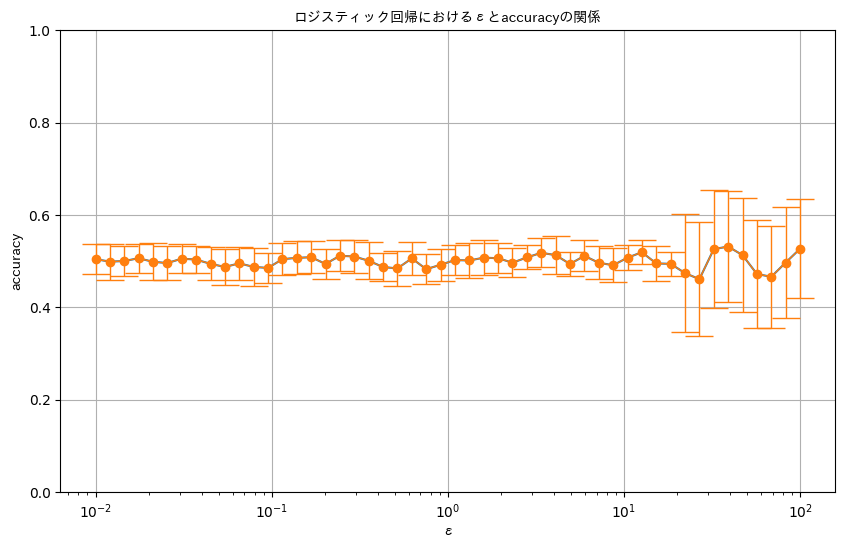

In [3]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
import numpy as np
import spacy
from typing import List, Tuple
import itertools
import matplotlib.pyplot as plt
from diffprivlib.models import LogisticRegression as DPLR
import matplotlib.font_manager as fm

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# データの正規化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 差分プライバシーなしのロジスティック回帰
clf = LogisticRegression(random_state=0).fit(X_train_scaled, y_train.to_numpy())
print("Non-DP accuracy: ", clf.score(X_test_scaled, y_test.to_numpy()))

# 差分プライバシーありのロジスティック回帰
import math

epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train_scaled).shape[1]
data_norm = math.sqrt(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=data_norm, epsilon=epsilon).fit(X_train_scaled, y_train.to_numpy())
        accuracy.append(clf.score(X_test_scaled, y_test.to_numpy()))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε', fontproperties=font_prop)
plt.ylabel('accuracy', fontproperties=font_prop)
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()

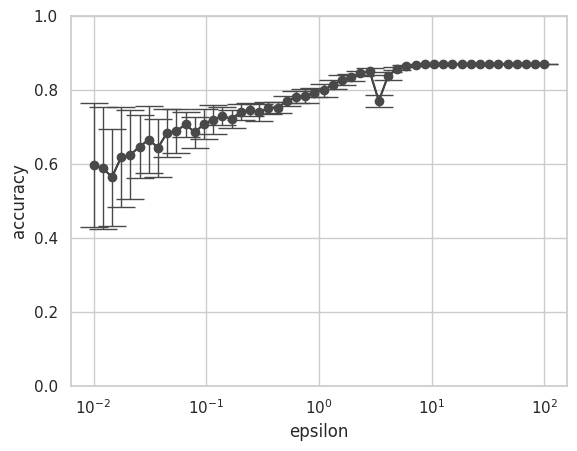

## 差分プライバシーありのロジスティック回帰　大きなεの範囲

/tmp/ipykernel_984731/728075650.py:48: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


Non-DP accuracy:  0.7083708370837084


/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:423: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:423: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:423: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:423: ConvergenceWarning: l

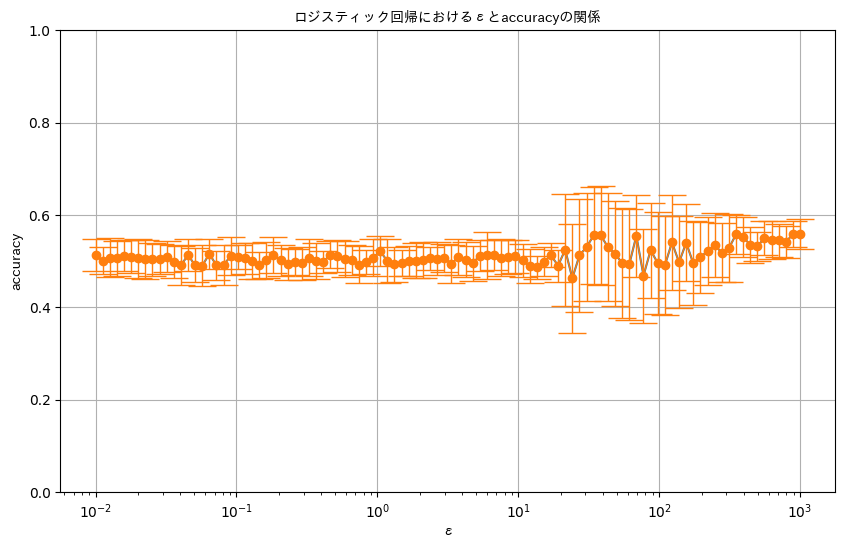

In [4]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import spacy
from typing import List, Tuple
import itertools
import matplotlib.pyplot as plt
from diffprivlib.models import LogisticRegression as DPLR
import matplotlib.font_manager as fm

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# データの正規化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 差分プライバシーなしのロジスティック回帰
clf = LogisticRegression(random_state=0).fit(X_train_scaled, y_train.to_numpy())
print("Non-DP accuracy: ", clf.score(X_test_scaled, y_test.to_numpy()))

# 差分プライバシーありのロジスティック回帰
import math

# εの範囲を拡大
epsilons = np.logspace(-2, 3, 100)
dim = np.array(X_train_scaled).shape[1]
data_norm = math.sqrt(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=data_norm, epsilon=epsilon).fit(X_train_scaled, y_train.to_numpy())
        accuracy.append(clf.score(X_test_scaled, y_test.to_numpy()))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε', fontproperties=font_prop)
plt.ylabel('accuracy', fontproperties=font_prop)
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()

## TF-IDFを使用した差分プライバシー付きロジスティック回帰

In [5]:
# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)

# 欠損値の確認
print(df.isnull().sum())

# 欠損値の削除
df = df.dropna()

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
tfidf_bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = tfidf_bow.tolist()

# 欠損値の再確認
print(df.isnull().sum())

# 欠損値が残っている場合は再度削除
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = [list(x) for x in X_train]
X_test = [list(x) for x in X_test]

# 差分プライバシーなしのロジスティック回帰
clf = LogisticRegression(random_state=0).fit(X_train, y_train.to_numpy())
print("Non-DP accuracy: ", clf.score(X_test, y_test.to_numpy()))

review       0
sentiment    0
dtype: int64


/tmp/ipykernel_984731/346474164.py:39: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


review       0
sentiment    0
bow          0
dtype: int64
Non-DP accuracy:  0.7155715571557155


/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I})

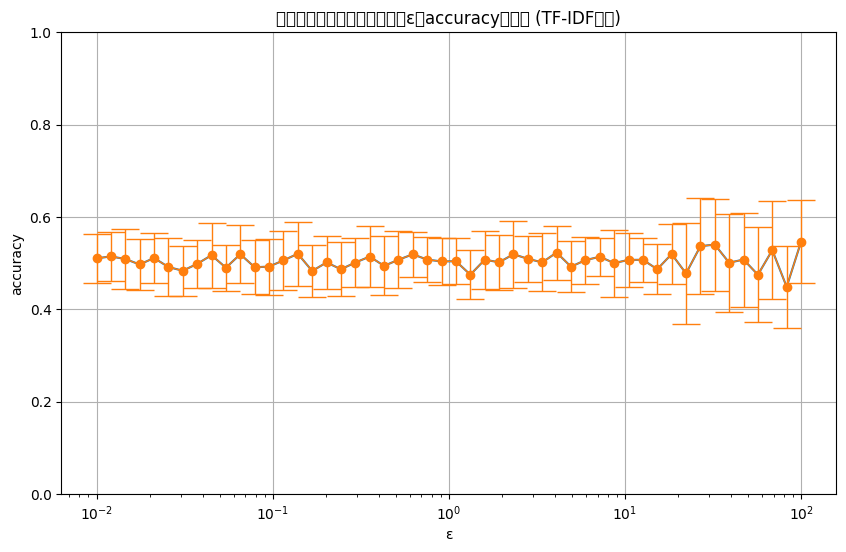

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import LogisticRegression as DPLR

epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train).shape[1]
data_norm = math.sqrt(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=data_norm, epsilon=epsilon).fit(X_train, y_train.to_numpy())
        accuracy.append(clf.score(X_test, y_test.to_numpy()))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係 (TF-IDF使用)')
plt.grid(True)
plt.show()


## 設定された閾値（Λ）を超える値は切り捨て（クランプ）する処理 + バイアス補正

/tmp/ipykernel_984731/200654788.py:49: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


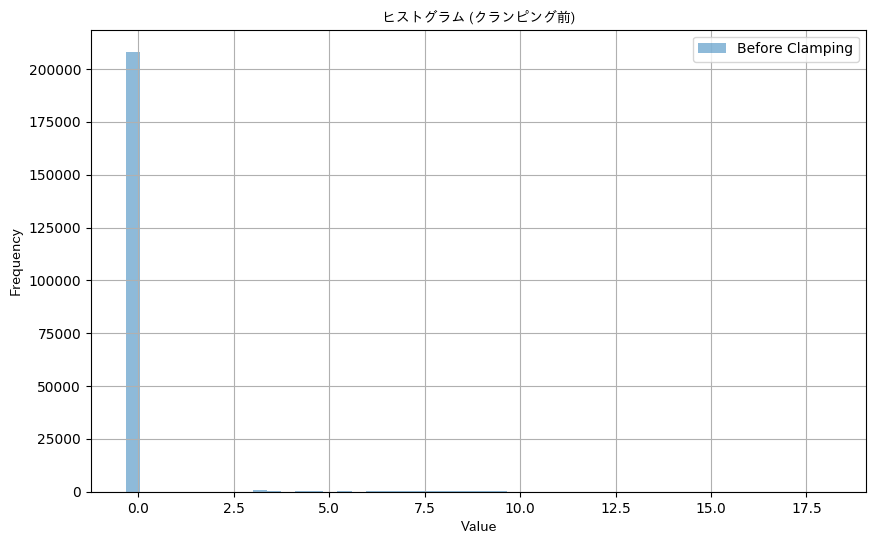

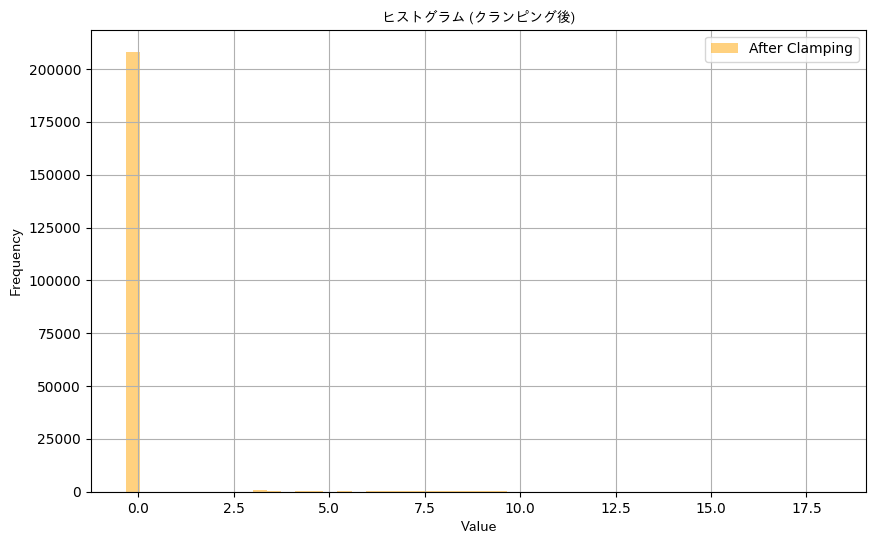

Non-DP accuracy:  0.7065706570657065


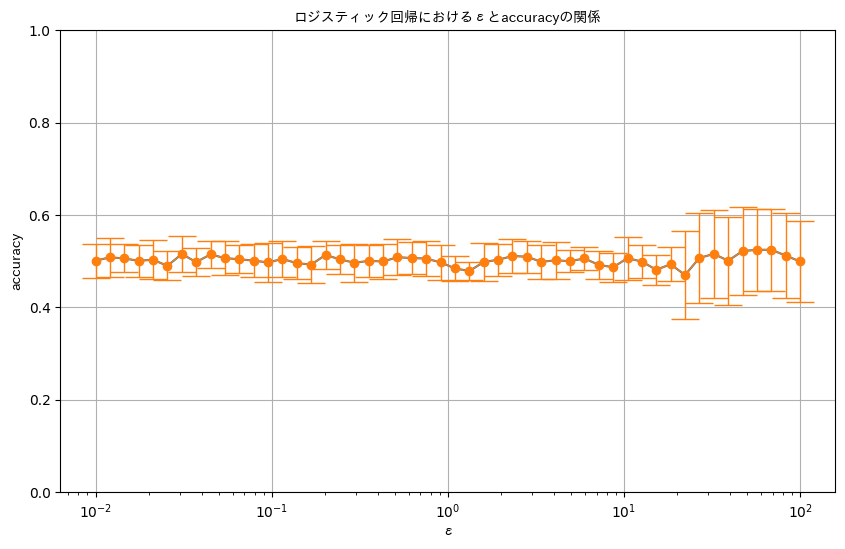

In [7]:
import math
import numpy as np
import pandas as pd
import spacy
from typing import List, Tuple
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from diffprivlib.models import LogisticRegression as DPLR
import matplotlib.font_manager as fm

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# データの正規化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# クランプ処理を追加
def clamp(data, lower, upper):
    return np.clip(data, lower, upper)

# ロジスティック回帰のための閾値設定
lower_bound = -100
upper_bound = 100

# クランピング前のヒストグラム表示
plt.figure(figsize=(10, 6))
plt.hist(X_train_scaled.flatten(), bins=50, alpha=0.5, label='Before Clamping')
plt.xlabel('Value', fontproperties=font_prop)
plt.ylabel('Frequency', fontproperties=font_prop)
plt.title('ヒストグラム (クランピング前)', fontproperties=font_prop)
plt.legend()
plt.grid(True)
plt.show()

X_train_clamped = clamp(X_train_scaled, lower_bound, upper_bound)
X_test_clamped = clamp(X_test_scaled, lower_bound, upper_bound)

# クランピング後のヒストグラム表示
plt.figure(figsize=(10, 6))
plt.hist(X_train_clamped.flatten(), bins=50, alpha=0.5, label='After Clamping', color='orange')
plt.xlabel('Value', fontproperties=font_prop)
plt.ylabel('Frequency', fontproperties=font_prop)
plt.title('ヒストグラム (クランピング後)', fontproperties=font_prop)
plt.legend()
plt.grid(True)
plt.show()

# 差分プライバシーなしのロジスティック回帰
clf = SklearnLogisticRegression(random_state=0).fit(X_train_clamped, y_train.to_numpy())
print("Non-DP accuracy: ", clf.score(X_test_clamped, y_test.to_numpy()))

# 差分プライバシーありのロジスティック回帰
epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train_clamped).shape[1]
data_norm = math.sqrt(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=data_norm, epsilon=epsilon).fit(X_train_clamped, y_train.to_numpy())
        accuracy.append(clf.score(X_test_clamped, y_test.to_numpy()))
    accuracies[epsilon] = accuracy

# バイアス補正
def bias_correction(accuracies, epsilons):
    corrected_accuracies = {}
    for epsilon in epsilons:
        corrected_accuracies[epsilon] = []
        for acc in accuracies[epsilon]:
            corrected_accuracies[epsilon].append(acc * (1 + (1 / epsilon)))
    return corrected_accuracies

corrected_accuracies = bias_correction(accuracies, epsilons)

# 結果をグラフに描画
x = epsilons
# y = [np.mean(corrected_accuracies[eps]) for eps in epsilons]
# e = [np.std(corrected_accuracies[eps]) for eps in epsilons]
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε', fontproperties=font_prop)
plt.ylabel('accuracy', fontproperties=font_prop)
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()


## バイアス補正コードの修正


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as SklearnLR
from diffprivlib.models import LogisticRegression as DPLR
import spacy
from typing import List, Tuple
import itertools
import math

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()
df

/tmp/ipykernel_984731/1391980650.py:45: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


,review,sentiment,bow
0,出張でお世話になりました。,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,朝食は普通でした。,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,また是非行きたいです。,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,また利用したいと思えるホテルでした。,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
4,駅から近くて便利でした。,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...
5548,スクランブルエッグにとても大きな殻が入っていてざりざりして気持ちが悪く未だに思い出します。,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5549,何組か食事してましたが、明らかにレストランではないスペース。,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5550,静かで居心地も良いしまた行きたい宿になりましたが、一点だけ残念だったのが夕食の海鮮舟盛りです。,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5551,チェックインして、部屋に入るとベッドルームの照明の位置もわかりにくく、大変な思いをしました。,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# クランピング
lower_bound = 0
upper_bound = 1.0
clamped_values = np.clip(X_train, lower_bound, upper_bound)

# クランピング前後のヒストグラムを表示
plt.figure(figsize=(10, 6))
plt.hist(X_train.flatten(), bins=50, alpha=0.5, label='Before Clamping')
plt.hist(clamped_values.flatten(), bins=50, alpha=0.5, label='After Clamping')
plt.legend()
plt.title('ヒストグラム（クランピング前後）')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 差分プライバシーなしのロジスティック回帰
clf = SklearnLR(random_state=0).fit(X_train, y_train)
print("Non-DP accuracy: ", clf.score(X_test, y_test))

# 差分プライバシーありのロジスティック回帰
epsilons = np.logspace(-2, 2, 50)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=upper_bound, epsilon=epsilon).fit(clamped_values, y_train)
        accuracy.append(clf.score(X_test, y_test))
    accuracies[epsilon] = accuracy

# バイアス補正
def bias_correction(estimated_values, clamped_values, lower, upper):
    alpha1 = np.mean(estimated_values < lower)
    alpha2 = np.mean(estimated_values > upper)
    theta_T = np.mean(clamped_values[(estimated_values >= lower) & (estimated_values <= upper)])
    corrected_estimates = -alpha1 * lower + (1 - alpha2 - alpha1) * theta_T + alpha2 * upper
    return corrected_estimates

corrected_accuracies = {}
for eps in epsilons:
    estimated_values_for_eps = np.array(accuracies[eps])
    clamped_estimated_values = np.clip(estimated_values_for_eps, lower_bound, upper_bound)
    corrected_accuracy = bias_correction(clamped_estimated_values, clamped_values.flatten(), lower_bound, upper_bound)
    corrected_accuracies[eps] = corrected_accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(corrected_accuracies[eps]) for eps in epsilons]
e = [np.std(corrected_accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()